# Kernel Comparison for Approximate Gaussian Process Classification
The kernel functions of the Radial Basis Function (RBF) and the Laplacian<br>
$$ k_{\text{RBF}}(\mathbf{x_1}, \mathbf{x_2}) = \exp \left( -\frac{1}{2} (\mathbf{x_1} - \mathbf{x_2})^\top \Theta^{-2} (\mathbf{x_1} - \mathbf{x_2}) \right) $$
$$ k_{\text{Laplacian}}(\mathbf{x_1}, \mathbf{x_2}) = \exp \left( - \left(\mathbf{x_1} - \mathbf{x_2}\right)^\top \Theta^{-1} \left(\mathbf{x_1} - \mathbf{x_2}\right) \right) $$
are fairly similar. However, the Laplacian kernel transform data differently than the RBF kernel and can be better suited for curve-shaped data, see e.g. [Bauckhage et al.](https://ieeexplore.ieee.org/document/9260042).<br>
In this notebook, the RBF and Laplacian kernel are compared on their suitability in a classification task, using an Approximate Gaussian Process as the classification model.

## Data
The data we will be looking at in this demonstration are two half-moon-shaped clusters of two-dimensional datapoints.

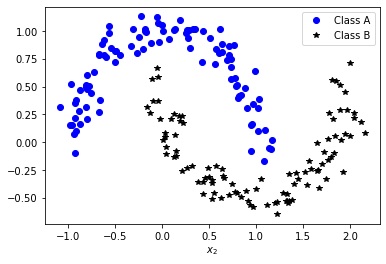

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import numpy

x, y = make_moons(n_samples=200, shuffle=False, noise=0.1, random_state=1)

plt.figure()
plt.plot(x[y == 0, 0], x[y == 0, 1], 'o', color='blue')
plt.plot(x[y == 1, 0], x[y == 1, 1], '*', color='black')
plt.legend(["Class A", "Class B"])
plt.xlabel(r'$x_1$')
plt.xlabel(r'$x_2$')
plt.show()

## Classifier
An Approximate Gaussian Process will be used as a classifier to identify members of class A (blue circles) in the above plot.

In [2]:
import gpytorch
import torch
from gpytorch.likelihoods import likelihood
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import UnwhitenedVariationalStrategy
from tqdm.notebook import tqdm

In [3]:
# Setting up the classification model
class GPClassificationModel(ApproximateGP):
    def __init__(self, train_x, base_kernel):
        variational_distribution = CholeskyVariationalDistribution(train_x.size(0))
        variational_strategy = UnwhitenedVariationalStrategy(
            self, train_x, variational_distribution, learn_inducing_locations=False
        )
        super(GPClassificationModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(base_kernel)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred

Randomly splitting the dataset into a training- and validation subset.

In [4]:
x = torch.from_numpy(x).float()
y = torch.from_numpy(y).float()

torch.random.manual_seed(0)
rands = torch.rand(len(y))
train_x = x[rands <= 0.8]
train_y = y[rands <= 0.8]
test_x = x[rands > 0.8]
test_y = y[rands > 0.8]


# Initialize likelihoods by using the RBF and the Laplacian Kernel
base_kernels = [gpytorch.kernels.RBFKernel(), gpytorch.kernels.LaplacianKernel()]
likelihoods = [gpytorch.likelihoods.BernoulliLikelihood() for _ in base_kernels]

# Initialize models by using the RBF and the Laplacian Kernel
models = [GPClassificationModel(train_x, base_kernel) for base_kernel in base_kernels]

Train the classifier using the `RBFKernel`:

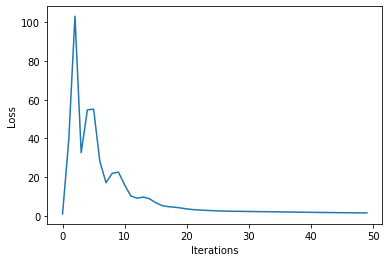

In [5]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 50
assert training_iterations > 2, "Why smoke_test?"  # TODO: Remove

# Model 1
rbf_model = models[0]
rbf_likelihood = likelihoods[0]

# Find optimal model hyperparameters
rbf_model.train()
rbf_likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(rbf_model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
# num_data refers to the number of training datapoints
mll = gpytorch.mlls.VariationalELBO(rbf_likelihood, rbf_model, train_y.numel())

losses = []
iterator = tqdm(range(training_iterations), desc="AGP Training")
for i in iterator:
    # Zero backpropped gradients from previous iteration
    optimizer.zero_grad()
    # Get predictive output
    output = rbf_model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    iterator.set_postfix(loss=loss.item())


plt.figure()
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Iterations")
plt.show()

Train the classifier using the `LaplacianKernel`:

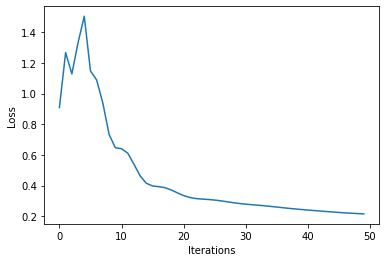

In [6]:
# Model 2
laplacian_model = models[1]
laplacian_likelihood = likelihoods[1]

# Find optimal model hyperparameters
laplacian_model.train()
laplacian_likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(laplacian_model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
# num_data refers to the number of training datapoints
mll = gpytorch.mlls.VariationalELBO(laplacian_likelihood, laplacian_model, train_y.numel())

losses = []
iterator = tqdm(range(training_iterations), desc="AGP Training")
for i in iterator:
    # Zero backpropped gradients from previous iteration
    optimizer.zero_grad()
    # Get predictive output
    output = laplacian_model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    iterator.set_postfix(loss=loss.item())
    

plt.figure()
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Iterations")
plt.show()

Evaluate the two models:

In [7]:
# Radial Basis Function Kernel
# Go into eval mode
rbf_model.eval()
rbf_likelihood.eval()
    
rbf_f_preds = rbf_model(test_x)
rbf_y_preds = rbf_likelihood(rbf_model(test_x))

rbf_f_mean = rbf_f_preds.mean
rbf_f_samples = rbf_f_preds.sample(sample_shape=torch.Size((1000,)))

with torch.no_grad():
    # Get classification predictions
    rbf_observed_pred = rbf_likelihood(rbf_model(test_x))

rbf_observed_pred = rbf_observed_pred.mean


# Laplacian Kernel
# Go into eval mode
laplacian_model.eval()
laplacian_likelihood.eval()

laplacian_f_preds = laplacian_model(test_x)
laplacian_y_preds = laplacian_likelihood(laplacian_model(test_x))

laplacian_f_mean = laplacian_f_preds.mean
laplacian_f_samples = laplacian_f_preds.sample(sample_shape=torch.Size((1000,)))

with torch.no_grad():
    # Get classification predictions
    laplacian_observed_pred = laplacian_likelihood(laplacian_model(test_x))

laplacian_observed_pred = laplacian_observed_pred.mean

## Results
The results on the test data (predicted labels) by the AGP model using the RBF and the laplacian kernel are shown in the following.

In [8]:
# compute the heatmaps
x_min, x_max = x.min(0)[0], x.max(0)[0]

xx, yy = torch.meshgrid([torch.linspace(x_min[i], x_max[i], 50) for i in range(len(x_min))])
rbf_contour, laplacian_contour = [], []
with torch.no_grad():
    for i in range(xx.shape[1]):
        rbf_contour.append(rbf_likelihood(rbf_model(torch.cat([xx[:, i:i + 1], yy[:, i:i + 1]], dim=1))).mean)
        laplacian_contour.append(laplacian_likelihood(laplacian_model(torch.cat([xx[:, i:i + 1], yy[:, i:i + 1]], dim=1))).mean)
rbf_contour = torch.stack(rbf_contour).t()
laplacian_contour = torch.stack(laplacian_contour).t()

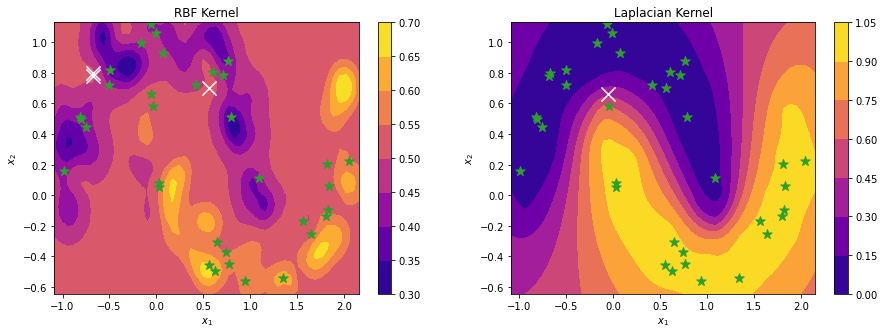

In [9]:
true_preds_rbf = numpy.array((rbf_observed_pred.numpy() >= 0.5) == (test_y.numpy() == 1))
false_preds_rbf = numpy.invert(true_preds_rbf)
true_preds_laplacian = numpy.array((laplacian_observed_pred.numpy() >= 0.5) == (test_y.numpy() == 1))
false_preds_laplacian = numpy.invert(true_preds_laplacian)

# Initialize fig and axes for plot
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
(ax1, ax2) = axs

# plot the results obtained using the RBF kernel
cs = ax1.contourf(xx, yy, rbf_contour, cmap=plt.cm.plasma)
ax1.scatter(test_x[true_preds_rbf, 0], test_x[true_preds_rbf, 1], edgecolor='tab:green', facecolor='tab:green', s=100, marker='*')
ax1.scatter(test_x[false_preds_rbf, 0], test_x[false_preds_rbf, 1], edgecolor='black', facecolor='white', s=200, marker='x')
fig.colorbar(cs, ax=ax1)
ax1.set_xlabel(r'$x_1$')
ax1.set_ylabel(r'$x_2$')
# ax1.legend(["Test Class A", "Test Class B", "Pred Class A", "Pred Class B"])
ax1.set_title("RBF Kernel")

# plot the results obtained using the Laplacian kernel
cs = ax2.contourf(xx, yy, laplacian_contour, cmap=plt.cm.plasma)
ax2.scatter(test_x[true_preds_laplacian, 0], test_x[true_preds_laplacian, 1], edgecolor='tab:green', facecolor='tab:green', s=100, marker='*')
ax2.scatter(test_x[false_preds_laplacian, 0], test_x[false_preds_laplacian, 1], edgecolor='black', facecolor='white', s=200, marker='x')
fig.colorbar(cs, ax=ax2)
ax2.set_xlabel(r'$x_1$')
ax2.set_ylabel(r'$x_2$')
# ax2.legend(["Test Class A", "Test Class B", "Pred Laplacian Class A", "Pred Laplacian Class B"])
ax2.set_title("Laplacian Kernel")

plt.show()

In the above figure, the correct classifications of class A and B are denoted by the *green* stars and wrong classifications are highlighted by the *white* crosses. The heatmap shows the contour of the AGP output, which is used for the classification.

Even though the difference of true/wrong classifiers by the two AGPs (using different kernels as covariance function) is small (both kernel functions do a good job), the heatmaps indicate that the *Laplacian* kernel might be better suited in this use case. The contours of the AGP using a Laplacian kernel show clear levels of high and low AGP outputs. The contours of the RBF-kernel based AGP (left subplot) however show a high number of local extrema (minima/maxima) of the AGP output. The RBF-kernel based AGP contours also lack a distinctive output in areas where few training data are available, see the bottom-left and upper-right corners of the left subplot. In these areas, the Laplacian-kernel based AGP (right subpot) shows a contour that is more easy to interprete.